In [ ]:
!pip install -U langchain-community

In [3]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 49.2 MB/s eta 0:00:00


In [25]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.0 MB/s eta 0:00:00


In [4]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from transformers import pipeline
import networkx as nx
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

import openai
import numpy as np

import ast
from wordcloud import WordCloud, STOPWORDS
import sklearn
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.decomposition import PCA
from tqdm import tqdm
from langchain.vectorstores import FAISS
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.llms import OpenAI

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_csv('/content/drive/MyDrive/news_with_embeddings.csv')
df.head()

,date,news,NER_entities,embeddings
0,2025-03-12t00:01:24z,google has updated its affiliate ads policy fo...,"google, chrome, paypal, honey, honey, ch...","[-0.021906452253460884, -0.002180565381422639,..."
1,2025-03-11t22:50:04z,the us department of justice antitrust divisio...,"us department of justice antitrust division, ...","[-0.003475295612588525, -0.0076425825245678425..."
2,2025-03-11t22:17:04z,"tesla stock plunged 15 percent on monday, its ...","tesla, tesla, elon musk, trump, tesla, m...","[-0.03681756556034088, -0.028674447908997536, ..."
3,2025-03-11t22:04:42z,at a white house event where he promised to bu...,"white house, tesla, donald trump, tesla, ...","[-0.04022103175520897, -0.03050697222352028, -..."
4,2025-03-11t18:05:28z,“big time” confusion has wracked the consumer ...,"consumer financial protection bureau, cfpb, ...","[-0.02165457420051098, -0.0125933438539505, -0..."


In [7]:
# define function to clean the text
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'\n+', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text.lower()
    return ""

text_columns = df.select_dtypes(include=["object"]).columns

for col in text_columns:
    df[col] = df[col].apply(clean_text)  #


In [ ]:
# load NER model
ner_model = pipeline("ner", model="Jean-Baptiste/roberta-large-ner-english", aggregation_strategy="simple")

entity_counter = Counter()
ner_entities = []

# loop through all documents and extract entities
for idx, text_sample in enumerate(df["news"].astype(str)):
    ner_results = ner_model(text_sample)  #
    entities = [entity['word'] for entity in ner_results]
    ner_entities.append(", ".join(entities))
    for entity in entities:
        entity_counter[entity] += 1

    # print out the process every 10 records
    if (idx + 1) % 10 == 0:
        print(f"Processed {idx + 1}/{len(df)} articles...")

df["NER_entities"] = ner_entities

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/849 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Processed 10/337 articles...
Processed 20/337 articles...
Processed 30/337 articles...
Processed 40/337 articles...
Processed 50/337 articles...
Processed 60/337 articles...
Processed 70/337 articles...
Processed 80/337 articles...
Processed 90/337 articles...
Processed 100/337 articles...
Processed 110/337 articles...
Processed 120/337 articles...
Processed 130/337 articles...
Processed 140/337 articles...
Processed 150/337 articles...
Processed 160/337 articles...
Processed 170/337 articles...
Processed 180/337 articles...
Processed 190/337 articles...


In [ ]:
# Ensure you have an OpenAI API key
openai.api_key = 'xxxxxxxxx'

In [ ]:

# Function to get embedding
def get_embedding(text, model="text-embedding-ada-002"):
    try:
        response = openai.embeddings.create(input=[text], model=model)  # Updated syntax
        return response.data[0].embedding  # Extract embedding vector
    except Exception as e:
        print(f"Error processing text: {e}")
        return None

# Apply embedding to each row with a progress bar
tqdm.pandas()
df["embeddings"] = df["news"].astype(str).progress_apply(get_embedding)

100%|██████████| 337/337 [01:23<00:00,  4.03it/s]


In [8]:
df.head()

,date,news,NER_entities,embeddings
0,2025-03-12t00:01:24z,google has updated its affiliate ads policy fo...,"google, chrome, paypal, honey, honey, chrome, ...","[-0.021906452253460884, -0.002180565381422639,..."
1,2025-03-11t22:50:04z,the us department of justice antitrust divisio...,"us department of justice antitrust division, g...","[-0.003475295612588525, -0.0076425825245678425..."
2,2025-03-11t22:17:04z,"tesla stock plunged 15 percent on monday, its ...","tesla, tesla, elon musk, trump, tesla, musk, �...","[-0.03681756556034088, -0.028674447908997536, ..."
3,2025-03-11t22:04:42z,at a white house event where he promised to bu...,"white house, tesla, donald trump, tesla, tesla...","[-0.04022103175520897, -0.03050697222352028, -..."
4,2025-03-11t18:05:28z,“big time” confusion has wracked the consumer ...,"consumer financial protection bureau, cfpb, ad...","[-0.02165457420051098, -0.0125933438539505, -0..."


In [ ]:
file_path = "/content/drive/MyDrive/news_with_embeddings.csv"
df.to_csv(file_path, index=False)

In [9]:
# ✅ 确保 embeddings 是列表格式（从字符串转换为 NumPy 数组）
df["embeddings"] = df["embeddings"].apply(lambda x: np.array(x))  # 转换嵌入向量

# ✅ 创建 LangChain 文档对象（包括文本 + 元数据）
documents = [
    Document(page_content=row["news"], metadata={"date": row["date"], "NER_entities": row["NER_entities"]})
    for _, row in df.iterrows()
]

# ✅ 直接使用已有的嵌入向量
embedding_vectors = np.vstack(df["embeddings"].values)


In [11]:
#  Load OpenAI embeddings model (ONLY for retrieval, NOT for creation)
embedding_model = OpenAIEmbeddings(openai_api_key=openai.api_key)

<ipython-input-11-f5e13ed7dc92>:2: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding_model = OpenAIEmbeddings(openai_api_key=openai.api_key)


In [14]:
print(df["embeddings"].values[:5])
print(type(df["embeddings"].values[0]))

['[-0.021906452253460884, -0.002180565381422639, 0.017108535394072533, -0.04147442430257797, -0.024916907772421837, 0.0062628258019685745, -0.009118728339672089, -0.012350938282907009, -0.013614255003631115, -0.028841255232691765, 0.023693909868597984, -0.017834270372986794, -0.0010575238848105073, -0.005819321144372225, -0.008621465414762497, -0.01337234303355217, 0.03281935676932335, -0.006450979504734278, 0.018076181411743164, -0.014850692823529243, -0.01827777549624443, 0.004015062935650349, -0.04021110758185387, 0.0008626505150459707, -0.017968665808439255, 0.02079096995294094, 0.02174517698585987, -0.023908942937850952, 0.0020848086569458246, -0.0034674014896154404, 0.005432934500277042, 0.010966665111482143, -0.01635592058300972, -0.001804258325137198, -0.0191110260784626, -0.01468941755592823, -0.0006467779166996479, -0.0012784362770617008, 0.013473139144480228, 0.015321076847612858, 0.00044560476089827716, -0.0016782626044005156, 0.008621465414762497, -0.013036354444921017, -0

In [18]:
# ✅ Convert stored embeddings into a NumPy array correctly
embedding_vectors = np.array([np.array(emb, dtype=np.float32) for emb in df["embeddings"].values])

# ✅ Check shape
print("Final embeddings shape:", embedding_vectors.shape)  # Should be (num_samples, embedding_dim)

Final embeddings shape: (337, 1536)


In [19]:
# # ✅ Extract text and embeddings
# texts = df["news"].tolist()  # The text content of the news
# embedding_vectors = [np.array(emb) for emb in df["embeddings"].values]  # Convert to list of arrays

# # ✅ Combine texts and embeddings into pairs (Fix the ValueError issue)
# text_embedding_pairs = list(zip(texts, embedding_vectors))

# # ✅ Create FAISS vector store from precomputed embeddings
# vector_db = FAISS.from_embeddings(text_embedding_pairs,embedding_model)

# # ✅ Save the FAISS index for future use
# vector_db.save_local("faiss_index")

vector_db = FAISS.from_embeddings(
    text_embeddings=list(zip(df["news"].tolist(), embedding_vectors)),
    embedding=embedding_model
)

# ✅ Save FAISS index
vector_db.save_local("faiss_index")

In [ ]:
api_key = 'xxxxxxxxxx'

In [21]:
# ✅ 载入 OpenAI LLM（你可以换成 GPT-4 或 GPT-3.5）
llm = ChatOpenAI(model_name="gpt-4o-mini", openai_api_key=api_key)

# ✅ 让 FAISS 作为 RAG 组件
# retriever = vector_db.as_retriever(search_kwargs={"k": 3})
retriever = vector_db.as_retriever()
qa_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever)

<ipython-input-21-0098591341c9>:2: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model_name="gpt-4o-mini", openai_api_key=api_key)


In [ ]:
query = "What are the latest updates about Tesla?"
response = qa_chain.run(query)

print("\nRAG Response:\n", response)

<ipython-input-47-a85324fc55b8>:2: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = qa_chain.run(query)



RAG Response:
 Tesla's stock recently plunged 15 percent, marking its steepest drop in five years, and is down over 50 percent since its December highs. The company is facing significant sales declines, with a reported 4 percent decrease in car production in 2024 compared to the previous year. Deliveries have remained flat, and sales have dropped sharply in multiple countries, including a nearly 8 percent decline in California.

Protests against Tesla and CEO Elon Musk have been occurring at showrooms across the U.S., driven by dissatisfaction with Musk's leadership and political alignment. Additionally, there are concerns about the aging vehicle lineup, as many Tesla models have not seen significant updates in years.

Musk has made promises regarding a more affordable electric vehicle, but progress on that front has been slow, and investors are worried about potential cannibalization of existing models. Meanwhile, competition in the electric vehicle market is increasing, particularly

In [36]:
def create_enriched_document(row):
    """
    Creates an enriched LangChain Document object from a news dataset row.
    This includes the news text, named entities, and metadata such as date.

    Args:
        row (pd.Series): A row from the dataframe.

    Returns:
        Document: A LangChain document object.
    """
    return Document(
        page_content=f"""
        Date: {row.get('date', 'Unknown')}
        News: {row['news']}
        **Named Entities:** {row.get('NER_entities', 'None')}
        """,
        metadata={
            "date": row.get("date", "Unknown"),  # Ensure "date" always exists
            "NER_entities": row.get("NER_entities", "None")
        }
    )

 # Apply document creation function to dataset
documents = [create_enriched_document(row) for _, row in df.iterrows()]

In [37]:
# Define improved smart retrieval function
def smart_retrieval(query):
    """
    Performs smart retrieval using FAISS, applying date-based filtering if a specific date is mentioned.
    Step 1: If query contains a date, filter retrieved results by that date.
    Step 2: Retrieve top results using FAISS similarity search.
    Step 3: Use LLM to rank and refine the results, allowing for partial matches.

    Args:
        query (str): The user's search query.

    Returns:
        str: The most relevant news articles.
    """
    import re
    from datetime import datetime

    # Extract date from query if present (basic YYYY-MM-DD or YYYY-MM regex)
    date_match = re.search(r"\b(202\d-\d{2}-\d{2})\b", query) or re.search(r"\b(202\d-\d{2})\b", query)
    search_date = date_match.group(0) if date_match else None

    # Step 1: Retrieve using FAISS
    retrieved_docs = vector_db.similarity_search(query, k=10)

    # Step 2: If a date is present, filter retrieved docs by that date
    if search_date:
        retrieved_docs = [doc for doc in retrieved_docs if search_date in doc.metadata["date"]]

    # Step 3: Convert retrieved documents into context for LLM
    context = "\n\n".join([doc.page_content for doc in retrieved_docs])

    # Step 4: Use LLM to rank results and allow partial matches
    ranked_response = llm.predict(f"""
    You are an AI news assistant. Analyze the retrieved news articles and return the most relevant ones.

    User Query: {query}

    Retrieved News Articles:
    {context}

    If the exact date '{search_date}' is not found, return the closest related news instead.
    """)

    return ranked_response

In [26]:
smart_retrieval("What happened on march 5th?")

<ipython-input-23-3a946873c04e>:33: LangChainDeprecationWarning: The method `BaseChatModel.predict` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  ranked_response = llm.predict(f"""


"Here are the most relevant news articles related to events around March 5th:\n\n1. **U.S. Stock Market Reactions to Tariffs**: On March 5th, stocks began the day with significant declines due to President Trump's tariffs on imports from Canada and Mexico. The S&P 500 index dropped by as much as 2% early in the trading day, reflecting investor uncertainty over the implications of these tariffs on the economy. The market later showed some recovery but ultimately ended lower. This situation highlighted concerns about the potential economic impact of the tariffs and the overall health of the economy.\n\n2. **Options Market Activity**: The article discusses a record surge in activity in the options market, specifically noting that about 59 million options contracts changed hands daily in February, a record high. This increase in activity comes as traders grapple with economic uncertainties, including Trump's tariff threats and inflation concerns, leading to heightened volatility in the sto

In [ ]:
smart_retrieval("Any new products that you like came out recently")

'Here are some of the most relevant new products that have been recently announced or released:\n\n1. **Framework Laptop 12**: A new repairable laptop that has garnered attention for its design and is expected to be popular among PC gamers.\n\n2. **Photoshop for iPhone**: For the first time, Adobe has released a mobile version of Photoshop that closely resembles the desktop experience, although it comes with a steeper learning curve.\n\n3. **Bose QuietComfort Ultra Earbuds**: These earbuds are noted for their best-in-class noise cancellation and have recently dropped in price to $219. They also feature a new transparency mode and improved sound quality.\n\n4. **Nothing Phone 3a and 3a Pro**: These new models come with improved hardware and a unique feature called "essential space" for organizing screenshots and voice memos. The 3a Pro includes a periscope telephoto lens.\n\n5. **Lenovo Thinkbook Flip Concept**: A laptop that can fold in multiple ways, offering a versatile screen size a

In [ ]:
smart_retrieval("How did the market did repsond to Trump? Give me the specific date")

"The most relevant news articles regarding the market's response to Trump, particularly focusing on precise dates, are as follows:\n\n1. **March 5, 2025**: U.S. stocks rebounded after the White House announced a one-month tariff reprieve for auto imports from Mexico and Canada. Stocks turned sharply higher after President Trump granted the exemption, indicating potential for more exemptions. The Dow Jones Industrial Average increased by 486 points while tech stocks like Ford and General Motors saw significant gains. However, concerns about the economy and inflation persisted, contributing to market volatility. \n\n2. **March 4, 2025**: U.S. stocks extended their slide after President Trump imposed tariffs on imports from Mexico and Canada, with the Dow Jones Industrial Average tumbling 1.6% (about 670 points). The S&P 500 and NASDAQ also experienced declines as investors reacted to uncertainty regarding the new tariffs and their implications for the economy. This marked a significant m

In [ ]:
smart_retrieval("What happened in China recently? Specify the date")

"Here are the most relevant news articles regarding recent events in China, along with their key details:\n\n1. **U.S.-China Trade Relations and Tariffs**  \n   - **Date:** March 5, 2024  \n   - **Summary:** China retaliated against new U.S. tariffs by imposing additional tariffs on various U.S. agricultural products, including a 15% tariff on chicken, wheat, corn, and cotton, and a 10% tariff on soybeans, pork, and other items. The tariffs are set to take effect on March 10. China also filed a lawsuit with the World Trade Organization and added U.S. companies to export control lists, signaling a firm stance amid escalating trade tensions.\n\n2. **Economic Growth Target Set by China**  \n   - **Date:** March 5, 2024  \n   - **Summary:** Amid the renewed trade war, China announced a growth target of about 5% for 2025, indicating expectations of resilience against U.S. trade pressures. The country plans to implement stimulus measures due to the economic challenges exacerbated by tariffs 

In [ ]:
smart_retrieval("你预测一下美股后面的走势？")

"Based on the retrieved news articles, here are the most relevant ones regarding the future outlook of the U.S. stock market:\n\n1. **Market Reaction to Tariffs and Trade Tensions**:\n   - U.S. stocks experienced significant volatility in response to President Trump's tariffs on imports from Mexico, Canada, and China. The Dow Jones Industrial Average dropped over 1.6%, and the S&P 500 saw its first correction since October 2023. Analysts noted that the uncertainty surrounding tariffs is unsettling the markets, which have been reacting sharply to new threats of tariffs. Investor sentiment appears to be turning cautious, influenced by fears of economic slowdown due to potential trade wars.\n\n2. **Economic Data and Market Sentiment**:\n   - Recent economic indicators suggest a slowing U.S. economy, with consumer spending dropping and mixed signals on inflation. While some investors remain optimistic and continue to invest in equities, there is growing caution among professionals. The vol

In [ ]:
def insight_retrieval(query):
    """
    Retrieves insights from relevant news articles without mentioning specific sources.
    The function will extract themes, trends, and key takeaways without listing retrieved articles.

    Args:
        query (str): The user's search question.

    Returns:
        str: A high-level summary of insights without referencing individual sources.
    """
    import re
    from datetime import datetime

    # Extract date from query if present (basic YYYY-MM-DD or YYYY-MM regex)
    date_match = re.search(r"\b(202\d-\d{2}-\d{2})\b", query) or re.search(r"\b(202\d-\d{2})\b", query)
    search_date = date_match.group(0) if date_match else None

    # Step 1: Retrieve using FAISS
    retrieved_docs = vector_db.similarity_search(query, k=10)

    # Step 2: If a date is present, filter retrieved docs by that date
    if search_date:
        retrieved_docs = [doc for doc in retrieved_docs if search_date in doc.metadata["date"]]

    # Step 3: Convert retrieved documents into context for LLM
    context = "\n\n".join([doc.page_content for doc in retrieved_docs])

    # Step 4: Use LLM to generate insights without referencing specific sources
    insights = llm.predict(f"""
    You are an expert financial analyst. Based on the retrieved information, summarize the key insights concisely.

    User Query: {query}

    Retrieved News Articles:
    {context}

    **Instructions:**
    - Do NOT mention specific sources or articles.
    - Provide only insights, trends, and key takeaways.
    - Use an analytical and objective tone.

    Provide the response in a structured and concise format.
    """)

    return insights

In [ ]:
insight_retrieval(smart_retrieval("你预测一下美股后面的走势？"))

"### Key Insights on U.S. Stock Market Trends and Predictions\n\n#### 1. **Market Response to Tariff Policies**\n   - Recent tariff impositions by the U.S. government have led to significant declines in major stock indices, including the Dow Jones, S&P 500, and Nasdaq Composite.\n   - The immediate market reaction indicates heightened uncertainty among investors regarding the economic impact of these tariffs, particularly on sensitive sectors such as automotive and banking.\n\n#### 2. **Investor Sentiment**\n   - Despite the downturn, retail investor confidence remains relatively strong, with continued investments in equities. However, this trend may not correlate with market stability, as retail investors historically tend to exit late in a market correction.\n   - A notable increase in bearish sentiment is observed, suggesting a potential for deeper market corrections if professional investors maintain caution.\n\n#### 3. **Economic Indicators and Market Volatility**\n   - Mixed econ

In [ ]:
insight_retrieval(smart_retrieval("评价一下特朗普最近的政策，我觉得他疯了，我不理解他为何又发动贸易战，你觉得呢？"))

"### Key Insights on Trump's Tariff Policies and Economic Impact\n\n#### 1. **Escalation of Trade Tensions**\n   - Trump's implementation of significant tariffs (25% on imports from Mexico and Canada, 10% on Chinese goods) marks a departure from decades of free trade, raising expectations of prolonged trade conflicts.\n\n#### 2. **Economic Fallout**\n   - The tariffs are anticipated to lead to higher consumer prices, with estimates suggesting a 1.2% increase in overall consumer costs and a potential 0.6% to 1% decrease in GDP growth.\n   - The economic environment is characterized by uncertainty, which could hinder hiring and investment decisions across various sectors.\n\n#### 3. **Industry Reactions**\n   - Different industries are reacting variably, with manufacturers, especially in the auto sector, expressing significant concern over cost implications and supply chain disruptions.\n   - Retailers are facing pressures to manage pricing strategies amid rising costs, which could dampe

In [29]:
import random
import json
from tqdm.auto import tqdm
from openai import OpenAI
from langchain.schema import Document

llm_client = OpenAI(api_key=api_key)
QA_generation_prompt = """
Your task is to generate a fact-based question and its answer using the given financial news article.
Ensure that the question can be directly answered using the article content.

Provide your response in this format:

Output:::
Factoid question: (your generated question)
Answer: (your answer)

Here is the news article:

{context}
Output:::
"""

def generate_qa_pairs(news_documents, n_samples=10):
    """Generates synthetic QA pairs from news articles using GPT."""
    qa_pairs = []
    sampled_docs = random.sample(news_documents, n_samples)

    for doc in tqdm(sampled_docs):
        context = doc.page_content
        response = llm_client.chat.completions.create(
            model="gpt-4",
            messages=[{"role": "system", "content": QA_generation_prompt.format(context=context)}]
        ).choices[0].message.content  # Extract content properly

        try:
            question = response.split("Factoid question: ")[-1].split("Answer: ")[0].strip()
            answer = response.split("Answer: ")[-1].strip()
            qa_pairs.append({"context": context, "question": question, "answer": answer})
        except:
            continue

    return qa_pairs

# Load documents and generate synthetic QA dataset
qa_dataset = generate_qa_pairs(documents, n_samples=20)

  0%|          | 0/20 [00:00<?, ?it/s]

In [38]:
# ✅ Step 1: Re-create LangChain Documents with updated metadata
documents = [create_enriched_document(row) for _, row in df.iterrows()]

# ✅ Step 2: Rebuild FAISS Index (Ensures metadata like "date" is stored)
vector_db = FAISS.from_documents(documents, embedding_model)

# ✅ Step 3: Save the updated FAISS index
vector_db.save_local("faiss_index")

In [39]:
def evaluate_rag_on_dataset(qa_dataset, rag_system):
    """Runs RAG system on the generated QA dataset and collects answers."""
    results = []

    for sample in tqdm(qa_dataset):
        question = sample["question"]
        ground_truth_answer = sample["answer"]

        # Get RAG-generated response
        rag_generated_answer = smart_retrieval(question)

        # Store results
        results.append({
            "question": question,
            "ground_truth": ground_truth_answer,
            "rag_answer": rag_generated_answer
        })

    return results

# Run evaluation
rag_results = evaluate_rag_on_dataset(qa_dataset, smart_retrieval)

  0%|          | 0/20 [00:00<?, ?it/s]

In [43]:
EVALUATION_PROMPT = """
You are an evaluator AI that checks the accuracy of AI-generated responses.
Compare the RAG-generated response with the ground truth answer.

Give a score on a scale of 1 to 5 based on:
- **5**: The response is completely factual and correct.
- **4**: The response is mostly correct with minor inaccuracies.
- **3**: The response is somewhat correct but misses key details.
- **2**: The response is mostly incorrect.
- **1**: The response is entirely wrong or hallucinates information.

Provide your answer in the following format:
Feedback: (Detailed reasoning for the rating)
Total Rating: (A number between 1 and 5)

Ground Truth Answer:
{ground_truth}

RAG-Generated Response:
{rag_answer}

Evaluation:
"""

def evaluate_rag_responses(rag_results):
    """Uses GPT-4 to evaluate RAG-generated answers vs. ground truth."""
    eval_results = []

    for sample in tqdm(rag_results):
        response = llm_client.chat.completions.create(
            model="gpt-4",
            messages=[{"role": "system", "content": EVALUATION_PROMPT.format(
                ground_truth=sample["ground_truth"], rag_answer=sample["rag_answer"]
            )}]
        )

        # ✅ Correctly extract the content from the first choice
        response_text = response.choices[0].message.content  # ✅ Use `.content` directly

        # Extract rating
        try:
            feedback = response_text.split("Feedback: ")[-1].split("Total Rating: ")[0].strip()
            rating = int(response_text.split("Total Rating: ")[-1].strip())
        except:
            feedback, rating = "Failed to extract feedback", 1

        eval_results.append({
            "question": sample["question"],
            "ground_truth": sample["ground_truth"],
            "rag_answer": sample["rag_answer"],
            "feedback": feedback,
            "rating": rating
        })

    return eval_results


# Run evaluation
evaluation_results = evaluate_rag_responses(rag_results)

# Convert to DataFrame
df_eval = pd.DataFrame(evaluation_results)

# Compute average faithfulness score
average_score = df_eval["rating"].mean()
print(f"📊 Average Faithfulness Score: {average_score:.2f}/5")

  0%|          | 0/20 [00:00<?, ?it/s]

📊 Average Faithfulness Score: 4.60/5


In [47]:
df_eval

,question,ground_truth,rag_answer,feedback,rating
0,Why is the General Services Administration pla...,The General Services Administration is plannin...,The most relevant news article regarding the G...,The RAG-generated response and the ground trut...,5
1,What did Commerce Secretary Howard Lutnick say...,"Trump's intention behind the decision was to ""...",The most relevant news articles regarding Comm...,The RAG-generated response is not directly ali...,3
2,What is the expectation of options traders reg...,Options traders are starting to position for a...,"Based on the retrieved news articles, the most...",The RAG-generated response covers the main poi...,4
3,What measure is being taken by American distil...,"American distillers, including Koval, are rush...",The most relevant news articles regarding the ...,The RAG-generated response accurately recaps t...,5
4,What new feature was announced for the Nothing...,The Nothing Phone 3a will include a new featur...,The most relevant articles regarding the new f...,The RAG-generated response gives a detailed re...,5
5,What percent increase did Deutsche Bank report...,Deutsche Bank reported a 17% increase in the v...,The most relevant news article regarding Deuts...,The RAG-Generated Response correctly included ...,5
6,Why is Illumina reducing its forecast for this...,Illumina is making these changes because China...,The most relevant articles regarding Illumina'...,The RAG-Generated Response accurately reflects...,5
7,What impact did Russian President Vladimir Put...,Russian President Vladimir Putin's comments ab...,The most relevant news articles regarding the ...,The RAG-Generated response accurately captures...,5
8,What is Huawei Technologies Co. Ltd. being inv...,Huawei Technologies Co. Ltd. is being investig...,The most relevant news article regarding the i...,The RAG-generated response provides accurate i...,4
9,What is the price of Xiaomi 15 Ultra and Xiaom...,"The Xiaomi 15 Ultra is priced at £1,299 / €1,4...",Based on your query about the price of the Xia...,The RAG-generated response accurately echoes t...,5


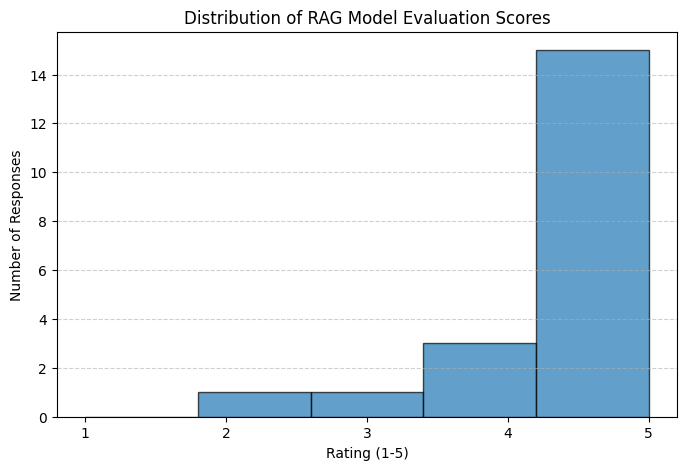

In [48]:
import matplotlib.pyplot as plt
import pandas as pd


# Plot histogram of ratings
plt.figure(figsize=(8, 5))
plt.hist(df_eval["rating"], bins=5, range=(1, 5), edgecolor="black", alpha=0.7)
plt.xlabel("Rating (1-5)")
plt.ylabel("Number of Responses")
plt.title("Distribution of RAG Model Evaluation Scores")
plt.xticks([1, 2, 3, 4, 5])
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


In [46]:
import json

qa_dataset_path = "/content/drive/MyDrive/qa_dataset.json"

# ✅ Save dataset as JSON
with open(qa_dataset_path, "w") as f:
    json.dump(qa_dataset, f, indent=4)

print(f"✅ `qa_dataset` saved at: {qa_dataset_path}")


rag_results_path = "/content/drive/MyDrive/rag_results.json"

# ✅ Save RAG results as JSON
with open(rag_results_path, "w") as f:
    json.dump(rag_results, f, indent=4)

print(f"✅ `rag_results` saved at: {rag_results_path}")

✅ `qa_dataset` saved at: /content/drive/MyDrive/qa_dataset.json
✅ `rag_results` saved at: /content/drive/MyDrive/rag_results.json
